In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [3]:
from tensorflow.keras.utils import to_categorical

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout, Reshape
from tensorflow.keras.regularizers import l2

In [5]:
from tensorflow.keras import backend as K

## Extracción de datos

In [6]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')

In [7]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


In [8]:
df_train.head().T

,30188,30189,30190,30191,30192
index,34565,34566,34567,34568,34569
Store,0,1,2,3,4
DayOfWeek,1,1,1,1,1
Date,2015-06-30 00:00:00,2015-06-30 00:00:00,2015-06-30 00:00:00,2015-06-30 00:00:00,2015-06-30 00:00:00
Sales,5735,9863,13261,13106,6635
...,...,...,...,...,...
Promo_bw,2,2,2,2,2
SchoolHoliday_bw,0,0,2,0,0
StateHoliday_bool_fw,0,0,0,0,0
Promo_fw,4,4,4,4,4


## Funciones auxiliares

In [9]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))

In [10]:
def get_metric(df, sales_):
    return np.sqrt((((df['Sales'] - sales_)/df['Sales'])**2).mean())

In [11]:
def get_cat_vars_model(cat_vars, uniques, cat_var_dict):
    cat_vars_embed_outs = []
    cat_var_inputs = []
    for cat_var in cat_vars:
        cat_var_in = Input(shape=(1,), name=f"{cat_var}_input")
        cat_var_inputs.append(cat_var_in)
        embed_out = Embedding(uniques[cat_var][0], cat_var_dict[cat_var], name=f'{cat_var}_Embed')(cat_var_in)
        flatten_out = Flatten(name=f"{cat_var}_flat")(embed_out)
        cat_vars_embed_outs.append(flatten_out)
    return cat_var_inputs, cat_vars_embed_outs

def get_cont_vars_input(contin_vars, dense_layer=False):
    cont_vars_inputs = []
    cont_vars_outputs = []
    for cont_var in contin_vars:
        cont_var_in = Input(shape=(1,), name=f"{cont_var}_input")
        cont_vars_inputs.append(cont_var_in)
        if dense_layer:
            cont_var_out = Dense(1, name=f"{cont_var}_input", activation = 'linear')(cont_var_in)
            cont_vars_outputs.append(cont_var_out)
        else:
            cont_vars_outputs.append(cont_var_in)
    return cont_vars_inputs, cont_vars_outputs

## Defino mis variables categoricas y continuas

In [12]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday',  'Promo2Weeks', 'Promo', 'SchoolHoliday', 'Open',
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw']

#min cat vars
cat_vars = ['Store','DayOfWeek']
#Conjunto 1 catvars
cat_vars = ['Store','DayOfWeek', 'Promo_fw', 'Promo_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw']
#Conjunto 2 catvars
cat_vars = ['Store','DayOfWeek', 'Promo_fw', 'Promo_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw','StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear']
#Conjunto 3 catvars
cat_vars = ['Store','DayOfWeek','Promo_fw', 'Promo_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw',
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events']
#Conjunto 4 catvars
cat_vars = ['Store','DayOfWeek', 'Year', 'Month', 'Day','SchoolHoliday', 'StateHoliday','Promo',
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events','Promo_fw', 'Promo_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw']

In [13]:
contin_vars = ['CompetitionDistance', 'CompetitionDaysOpen','CompetitionMonthsOpen',
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC','CloudCover', 'trend', 'trend_DE'
   ]

#Reducidas
contin_vars = ['CompetitionDistance', 'Max_TemperatureC']
#Completas
contin_vars = ['CompetitionDistance', 'CompetitionDaysOpen','CompetitionMonthsOpen',
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC','CloudCover', 'trend', 'trend_DE'
   ]

In [14]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [15]:
uniques.T

,uniques
Store,1115
DayOfWeek,7
Year,3
Month,12
Day,31
SchoolHoliday,2
StateHoliday,4
Promo,2
StoreType,4
Assortment,3


## Baseline
Se obtiene un score del 30% estimando por la media.

In [16]:
stores_mean = {}
for store, g_df in df_train.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [17]:
df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)

df_train.loc[:, 'Sales_store'] = df_train['Sales'] - df_train['mean_by_store']
df_val.loc[:, 'Sales_store'] = df_val['Sales'] - df_val['mean_by_store']

C:\Users\germa\AppData\Local\Temp\ipykernel_16036\3553976367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
C:\Users\germa\AppData\Local\Temp\ipykernel_16036\3553976367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)
C:\Users\germa\AppData\Local\Temp\ipykernel_16036\3553976367.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [18]:
get_metric(df_val, df_val['mean_by_store'])

0.30717460853388645

# Asignación de dimensión de embeddings

In [19]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 2, 'Year': 2, 'Open': 2,'Month': 2, 'CloudCover': 2,
'Day': 10, 'StateHoliday': 2, 'CompetitionMonthsOpen': 2, 'SchoolHoliday': 2,'Promo': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 25, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_bool_fw': 1,
'StateHoliday_bool_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

In [20]:
for v in cat_vars:
    uniques_ = df[v].unique()
    uniques_.sort()
    print(v, cat_var_dict[v], len(uniques_), uniques_)
    print()

Store 50 1115 [   0    1    2 ... 1112 1113 1114]

DayOfWeek 2 7 [0 1 2 3 4 5 6]

Year 2 3 [0 1 2]

Month 2 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Day 10 31 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]

SchoolHoliday 2 2 [0 1]

StateHoliday 2 4 [0 1 2 3]

Promo 2 2 [0 1]

StoreType 2 4 [0 1 2 3]

Assortment 3 3 [0 1 2]

PromoInterval 3 4 [0 1 2 3]

CompetitionOpenSinceYear 4 21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]

Promo2SinceYear 4 8 [0 1 2 3 4 5 6 7]

State 6 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Week 25 52 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]

Events 4 22 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]

Promo_fw 1 6 [0 1 2 3 4 5]

Promo_bw 1 6 [0 1 2 3 4 5]

SchoolHoliday_fw 1 8 [0 1 2 3 4 5 6 7]

SchoolHoliday_bw 1 8 [0 1 2 3 4 5 6 7]

StateHoliday_bool_fw 

# Definición de modelo

Variables de control

In [21]:
add_customers = True
log_output = False
output_activation = 'linear'
first_hidden_units = 1000
second_hidden_units = 200
l2_lambda = 1e-3

Modelo 1

In [22]:
def get_model_1():
    
    cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
    cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

    
    merged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)
    x = Dense(first_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(merged)
    #x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = LeakyReLU()(x)
    x = Dense(second_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(x)
    #x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = LeakyReLU()(x)

    output_1 = Dense(1, name='Sales', activation=output_activation)(x)
    output_2 = Dense(1, name='Customers', activation=output_activation)(x)
    

    if add_customers:
        model = Model(cat_var_inputs + cont_vars_inputs, [output_1, output_2])
    else: 
        model = Model(cat_var_inputs + cont_vars_inputs, [output_1])
    model.compile(optimizer=Adam(lr=lr), metrics=['mse', rmspe], loss='mse')
    model.summary()   
    model.save_weights('initial_weights.hdf5')
    
    return model

Modelo 2

In [23]:
def get_model_2():
    
    
    cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
    cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

    
    merged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)
    output_model = Dense(2000, kernel_initializer="uniform")(merged)
    output_model = Activation('relu')(output_model)
    output_model = Dense(200, kernel_initializer="uniform")(output_model)
    output_model = Activation('relu')(output_model)
    output_model = Dense(1)(output_model)
    output_model = Activation('sigmoid')(output_model)

    output_1 = Dense(1, name='Sales', activation=output_activation)(output_model)
    output_2 = Dense(1, name='Customers', activation=output_activation)(output_model)
    

    if add_customers:
        model = Model(cat_var_inputs + cont_vars_inputs, [output_1, output_2])
    else: 
        model = Model(cat_var_inputs + cont_vars_inputs, [output_1])
    
    model.compile(optimizer=Adam(lr=lr), metrics=['mse', rmspe], loss='mse')
    model.summary()   
    model.save_weights('initial_weights.hdf5')
    
    
    return model

Elijo el modelo a utilizar

In [ ]:
model=get_model_1()

In [ ]:
from matplotlib import pyplot as plt
# plt.figure(figsize=(20,5))
# plt.plot((df_train[df_train['Store']==1]['Sales'].values - df_train[df_train['Store']==1]['Sales'].mean())/df_train[df_train['Store']==1]['Sales'].std())
# plt.show()
# plt.figure(figsize=(20,5))
# plt.plot(np.log(df_train[df_train['Store']==1]['Sales'].values)/np.max(np.log(df_train[df_train['Store']==1]['Sales'].values)))
# plt.show()

Separo mis datos

In [ ]:
all_vars = cat_vars + contin_vars

X_train = np.hsplit(df_train[all_vars].values, len(all_vars))
X_val = np.hsplit(df_val[all_vars].values, len(all_vars))
X_test = np.hsplit(df_test[all_vars].values, len(all_vars))

In [ ]:
if add_customers:
    y_out_columns = ['Sales', 'Customers']
else:
    y_out_columns = ['Sales_store']
    
if log_output:
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns])).values
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
    #y_mean = df_train[y_out_columns].mean().values
    #y_std = df_train[y_out_columns].std().values
    #y_train = (df_train[y_out_columns].values - y_mean)/y_std
    #y_val = (df_val[y_out_columns].values - y_mean)/y_std
    
    y_max = df_train[y_out_columns].max().values
    y_train = df_train[y_out_columns].values/y_max
    y_val = df_val[y_out_columns].values/y_max
y_train = np.hsplit(y_train, y_train.shape[1])
y_val = np.hsplit(y_val, y_val.shape[1])

Fijo hiperparametros

In [ ]:
lr = 0.001
epochs = 20
batch_size = 1024


In [ ]:
if add_customers:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_Sales_rmspe', verbose=1, save_best_only=True)
else:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], verbose=2)

In [ ]:
plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_Customers_mse'])
# plt.plot(history.history['val_Sales_mse'])
plt.show()
plt.plot(history.history['loss'])
# plt.plot(history.history['Customers_mse'])
# plt.plot(history.history['Sales_mse'])

## Resultados
Se varió de modelo y de variables de entrada al mismo. Se empezó por tomar la menor cantidad de variables, ya sean categóricas o continuas. Se normalizaron las continuas y se realizó un trabajo de embedding sobre las categóricas.

Se probó realizar batch normalization pero no hubo mejora.

Se varió el método de optimización, siendo el utilizado finalmente para las pruebas finales Adam.

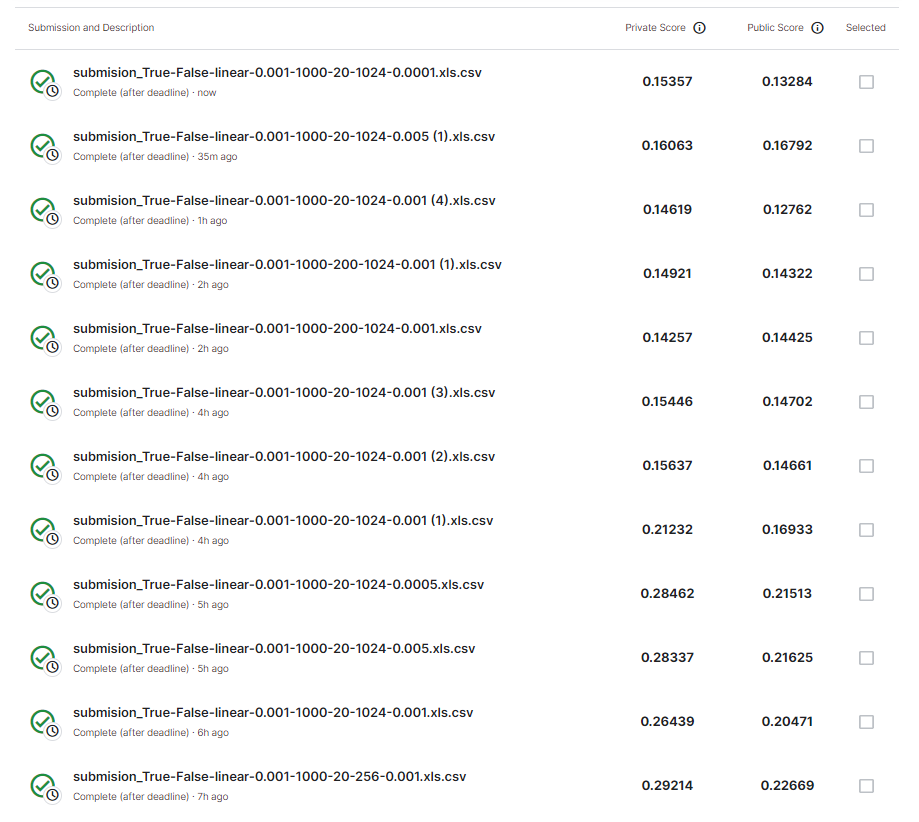

Se probaron 11 variaciones para estimar las ventas. Las mismas se presenta en la siguiente tabla.

| **Score** | **Batch Size** | **Learning Rate** | **Var. Continuas** | **Var. Categóricas** | **Modelo** |
|:---------:|:--------------:|:-----------------:|:------------------:|:--------------------:|:----------:|
|  0.22669  |      1024      |       0.005       |      Reducidas     |        Minímas       |      1     |
|  0.20471  |      1024      |       0.005       |      Completas     |        Minímas       |      1     |
|  0.21625  |       521      |       0.001       |      Reducidas     |        Minímas       |      1     |
|  0.21513  |      1024      |       0.001       |      Completas     |        Minímas       |      1     |
|  0.16913  |      1024      |       0.001       |      Completas     |      Conjunto 1      |      1     |
|  0.14661  |      1024      |       0.001       |      Completas     |      Conjunto 2      |      1     |
|  0.14702  |      1024      |       0.001       |      Completas     |      Conjunto 3      |      1     |
|  0.14425  |      1024      |       0.001       |      Completas     |      Conjunto 4      |      1     |
|  0.12762  |      1024      |       0.001       |      Completas     |      Conjunto 4      |      2     |
|  0.16792  |      1024      |       0.005       |      Completas     |      Conjunto 4      |      2     |
|  0.13284  |      1024      |       0.0001      |      Completas     |      Conjunto 4      |      2     |

El mejor valor obtenido fue una métrica de **0.12762** utilizando toda la información disponbile, con el modelo 2, $\alpha =0.001$ y $BS=1024$.

Capturas de los entrenamientos:

BS=1024 l=0.005 full contin_vars app4 catvars Model 2
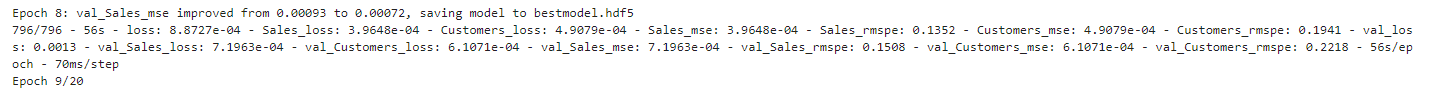

BS=1024 l=0.001 full contin_vars app4 catvars Model 2
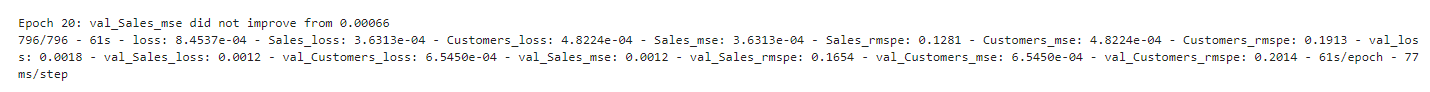

BS=1024 l=0.001 full contin_vars app4 catvars
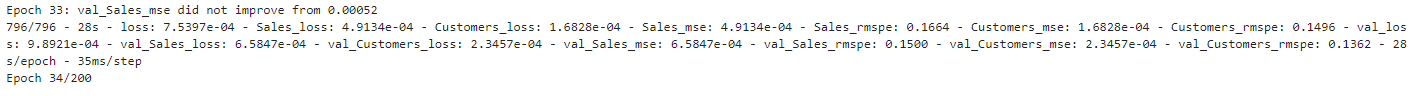

BS=1024 l=0.001 full contin_vars app3 catvars
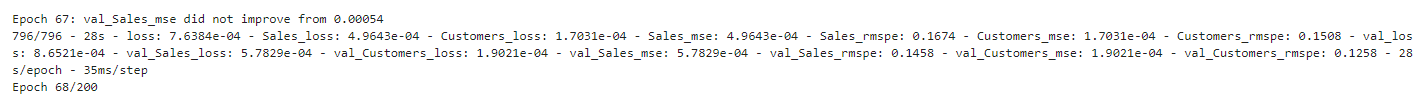

BS=1024 l=0.001 full contin_vars app2 catvars
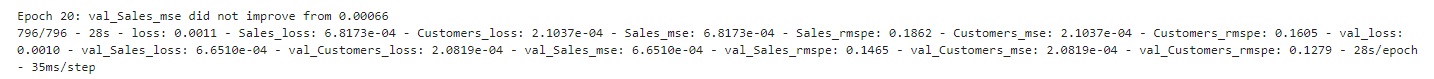

BS=1024 l=0.001 full contin_vars app1 catvars
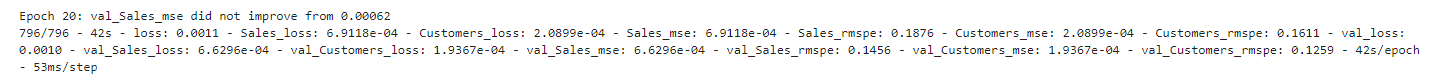

BS=1024 l=0.001 full contin_vars
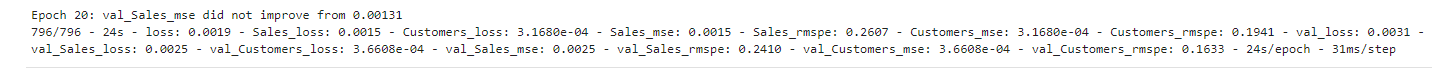

BS=1024 l=0.001
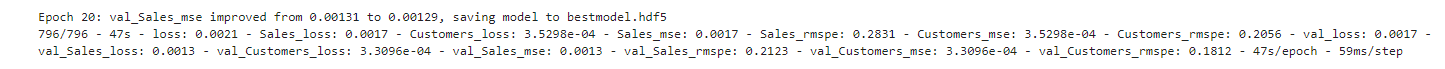

vars cat reducidas
BS=521 l=0.001
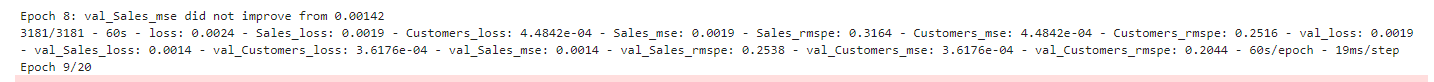

BS=1024 l=0.05
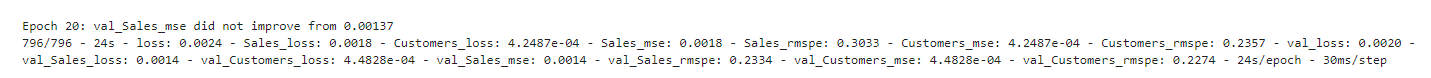

BS=1024 l=0.005
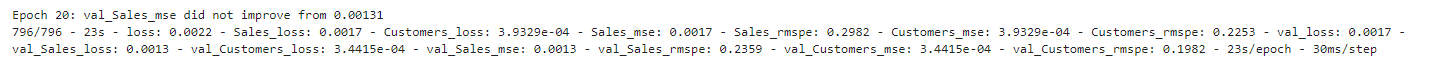

# Métrica

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [ ]:
model.evaluate(X_val, y_val)

In [ ]:
model.load_weights('bestmodel.hdf5')
model.evaluate(X_val, y_val)

In [ ]:
if log_output:
    if add_customers:
        y_pred = np.exp(model.predict(X_val, verbose=1)[0][:, 0]*max_log_y[0])
        y_pred_test = np.exp(model.predict(X_test, verbose=1)[0][:, 0]*max_log_y[0])
    else:
        y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)[:,0]
        y_pred_test = np.exp(model.predict(X_test, verbose=1)*max_log_y)[:,0]
else:
    if add_customers:
#        y_pred = (model.predict(X_val, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
#        y_pred_test = (model.predict(X_test, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
        y_pred = model.predict(X_val, verbose=1)[0]*y_max[0]
        y_pred_test = model.predict(X_test, verbose=1)[0]*y_max[0]
    else:
#        y_pred = model.predict(X_val, verbose=1)[:,0]*y_std + y_mean
#        y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_std + y_mean
        y_pred = model.predict(X_val, verbose=1)[:,0]*y_max
        y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_max

y_pred_test[df_test['Open'] == 0] = 0

# Sumbit a la competición

In [ ]:

sample_csv = pd.read_csv('rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submision_{add_customers}-{log_output}-{output_activation}-{l2_lambda}-{first_hidden_units}-{epochs}-{batch_size}-{lr}.csv', index=False)
